In [16]:
import torch
import pandas as pd
import tqdm
import re
import numpy as np
from datasets import load_dataset, load_from_disk
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cuda


In [17]:
dataset = load_dataset("imdb")

In [18]:
df = dataset['train'].to_pandas()

In [19]:
df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


<Axes: xlabel='label'>

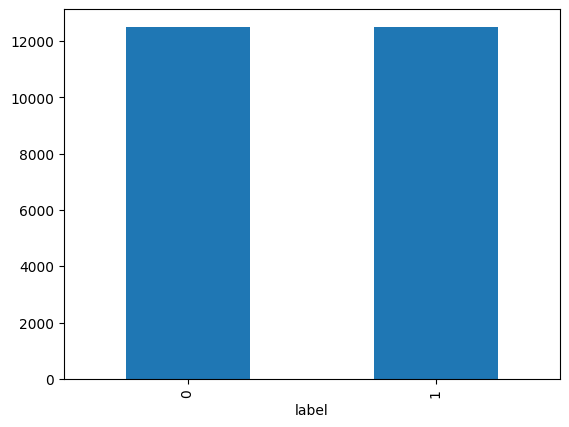

In [20]:
df["label"].value_counts().plot(kind="bar")

In [21]:
phrase_length = df["text"].apply(len).value_counts()

<Axes: ylabel='Frequency'>

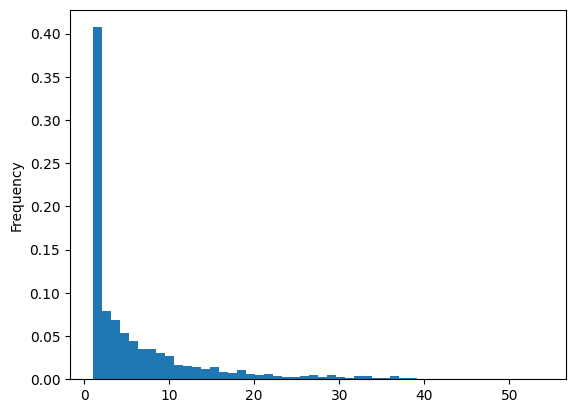

In [22]:
phrase_length.plot(kind="hist", bins=50, density=True)

In [23]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_text(batch):
    cleaned_texts = []
    for text in batch["text"]:
        text = text.lower()
        text = re.sub(r"[^a-z\s]", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
        cleaned_texts.append(text)
    return {"text": cleaned_texts, "label": batch["label"]}

def encode_batch(batch):
    cleaned = [clean_text(t) for t in batch["text"]]  # or your cleaner
    embeddings = model.encode(cleaned, convert_to_tensor=False)
    batch["embedding"] = [emb.tolist() for emb in embeddings]
    return batch


model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

cache_dir = Path("data")
train_cache = cache_dir / "imdb_train_encoded"
test_cache = cache_dir / "imdb_test_encoded"


if train_cache.exists() and test_cache.exists():
    train_encoded = load_from_disk(train_cache.as_posix())
    test_encoded = load_from_disk(test_cache.as_posix())
else:
    cache_dir.mkdir(parents=True, exist_ok=True)

    train_encoded = dataset['train'].map(encode_batch, batched=True, batch_size=64)
    test_encoded = dataset['test'].map(encode_batch, batched=True, batch_size=64)

    train_encoded.save_to_disk(train_cache.as_posix())
    test_encoded.save_to_disk(test_cache.as_posix())

In [24]:
clf = LogisticRegression(max_iter=1000)

X_train = np.array([emb for emb in train_encoded["embedding"]])
y_train = np.array(train_encoded["label"])
clf.fit(X_train, y_train)

X_test = np.array([emb for emb in test_encoded["embedding"]])
y_test = np.array(test_encoded["label"])
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.81      0.82      0.82      6267
    positive       0.82      0.81      0.81      6233

    accuracy                           0.82     12500
   macro avg       0.82      0.82      0.82     12500
weighted avg       0.82      0.82      0.82     12500



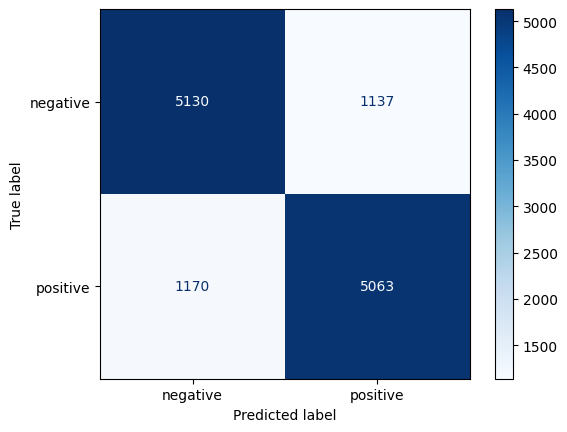

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["negative", "positive"])
disp.plot(cmap="Blues")

In [26]:
positive = "Wow this movie was amazing! I loved it."
negative = "This was the worst movie I have ever seen."
neutral = "Its alright. Not too bad, not too good."


for phrase in (positive, negative, neutral):
    cleaned = clean_text(phrase)
    embedding = model.encode([cleaned], convert_to_tensor=False)
    pred = clf.predict(embedding)
    label = "positive" if pred[0] == 1 else "negative"
    print(f"Phrase: {phrase}\nPredicted sentiment: {label}\n")

Phrase: Wow this movie was amazing! I loved it.
Predicted sentiment: positive



Phrase: This was the worst movie I have ever seen.
Predicted sentiment: negative

Phrase: Its alright. Not too bad, not too good.
Predicted sentiment: positive

